In [1]:
import tensorflow as tf
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=128
BATCH_SIZE=32

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
"Potato",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


### Preprocessing converts image to an image array of RGB

In [4]:
class_names=dataset.class_names

In [ ]:
class_names

In [ ]:
for i in dataset.take(2):
    print(i)

### In the Dataset we defined in line 3, Each image will have img tensor and label. Label here is 0,1,2

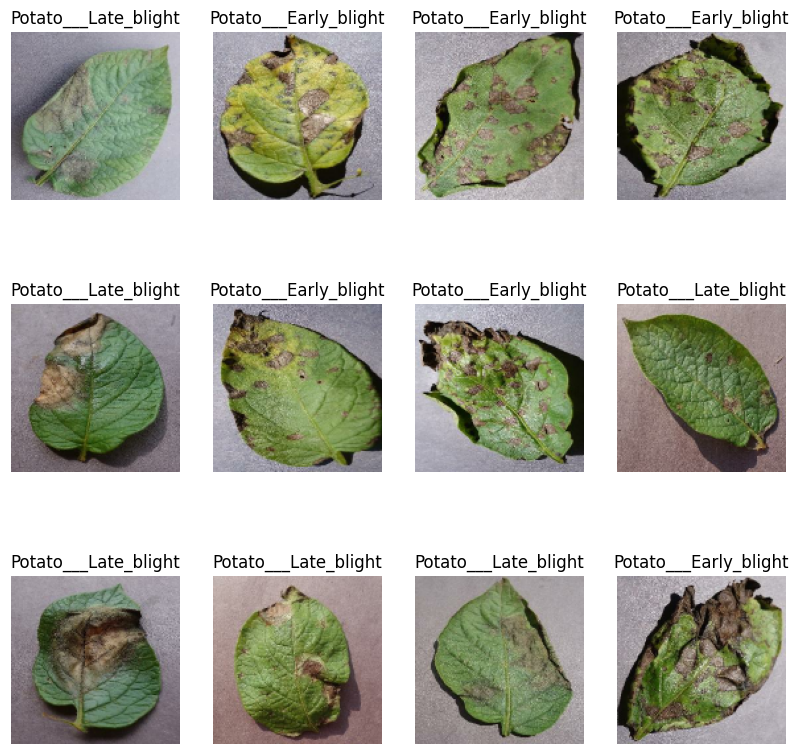

In [5]:
plt.figure(figsize=(10,10))
for img,label in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")
       
    

### We converted the img tensor to numpy followed by conversion to uint8 , img is xtrain and label is ytrain
###Since batch defined is 32, in each take there will be 32 images


### Training -80%, validation- 10%, Test-10%

In [ ]:
len(dataset)

In [ ]:
train_ds=int(0.8*len(dataset))

In [ ]:
train_ds

In [ ]:
vali_ds=int(0.1*len(dataset))
vali_ds

In [6]:
def divide(dataset,train=0.8,valid=0.1,test=0.1,shuffle=True,shuffle_size=1000):
    ds_size=len(dataset)
    if shuffle:
        dataset=dataset.shuffle(shuffle_size,seed=12)
    train_size=int(train*ds_size)
    val_size=int(valid*ds_size)
    train_ds=dataset.take(train_size)
    val_ds=dataset.skip(train_size).take(val_size)
    test_ds=dataset.skip(train_size+val_size)
    return train_ds,val_ds,test_ds
    

In [7]:
train_ds,val_ds,test_ds=divide(dataset)

In [ ]:
len(test_ds)

### Cache ing, shuffling and prefetching a dataset

In [8]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Data Augmentation  ,  we are creating layers which will be used in neural network

In [9]:
resize_and_rescale=tf.keras.Sequential(
  [layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255.0),
  ])

### In above layer, we did resize and rescale again to convert the image inputter during actual running to appropriate dimension

In [10]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [11]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [38]:
EPOCHS=3
CHANNELS=3

In [37]:
k=range(EPOCHS)
for i in range(7):
    print(k[i])

0
1
2
3
4
5
6


In [13]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3

### In convo2d, 32- no of filters, each of size 3,3  and then we will pool them to 2,2 matrix

In [14]:


model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

### No of pooling and filter layers is strictly hit & trial, We have only 1 hidden layer of (ANN), preceding layers were (CNN) 

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 128, 128, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 126, 126, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 63, 63, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 61, 61, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 30, 30, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 28, 28, 64)         

In [16]:
model.compile(
optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy'])

In [17]:
history=model.fit(
   train_ds,
   batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=3,
)

Epoch 1/3
54/54 [==============================] - 23s 377ms/step - loss: 0.8652 - accuracy: 0.5949 - val_loss: 0.7615 - val_accuracy: 0.7448
Epoch 2/3
54/54 [==============================] - 16s 291ms/step - loss: 0.5998 - accuracy: 0.7627 - val_loss: 0.6124 - val_accuracy: 0.7031
Epoch 3/3
54/54 [==============================] - 17s 311ms/step - loss: 0.3944 - accuracy: 0.8426 - val_loss: 0.2549 - val_accuracy: 0.8958


In [18]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 2s 57ms/step - loss: 0.3141 - accuracy: 0.8750


### Increasing the number of epochs will definitely increase the accuracy

### We will now start plotting the results on curves

In [19]:
scores

[0.31405675411224365, 0.875]

In [20]:
history.params

{'verbose': 1, 'epochs': 3, 'steps': 54}

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [27]:
len(history.history)

4

In [23]:
len(history.history)

4

In [30]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, ' Training vs Validation Loss')

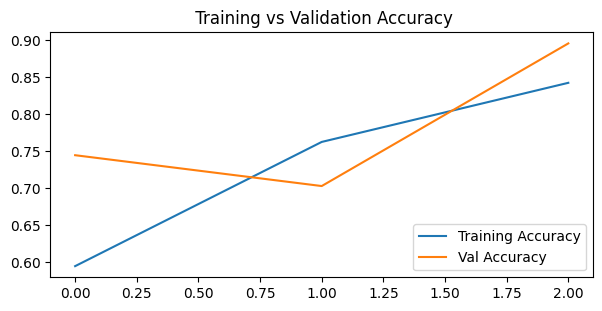

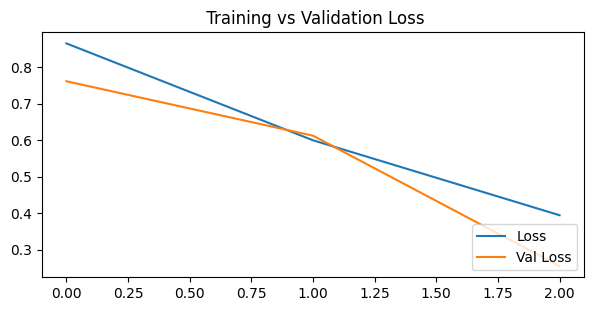

In [42]:
plt.figure(figsize=(7,7))
plt.subplot(2,1,1)
plt.plot(range(EPOCHS),acc,label="Training Accuracy")
plt.plot(range(EPOCHS),val_acc,label="Val Accuracy")
plt.legend(loc='lower right')
plt.title(" Training vs Validation Accuracy")
plt.figure(figsize=(7,7))
plt.subplot(2,1,2)
plt.plot(range(EPOCHS),loss,label="Loss")
plt.plot(range(EPOCHS),val_loss,label="Val Loss")
plt.legend(loc='lower right')
plt.title(" Training vs Validation Loss")



### if number is EPOCHS is high, comparable to 50, then graphs looks way better

In [56]:
import numpy as np
class_name=dataset.class_names

1/1 [==============================] - 0s 57ms/step


C:\Users\areek\AppData\Local\Temp\ipykernel_64320\1415170285.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,i+1)


1/1 [==============================] - 0s 61ms/step


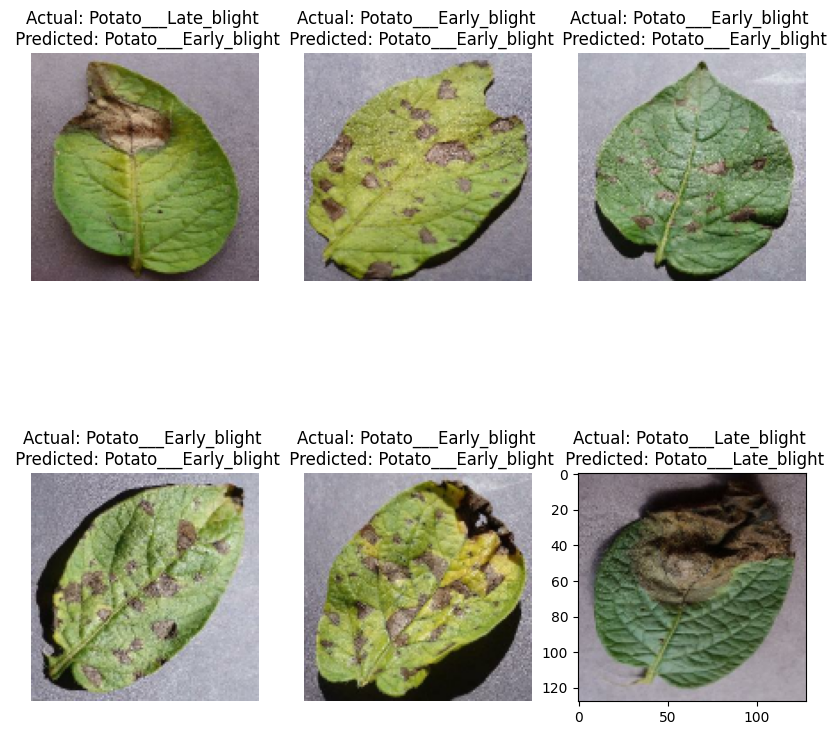

In [59]:
plt.figure(figsize=(10,10))
for img_batch,label_batch in test_ds.take(1):
    for i in range(6):
        plt.axis("off")
        
        plt.subplot(2,3,i+1)
        ini_img=img_batch[i].numpy().astype('uint8')
        ini_lab=label_batch[i].numpy()
        plt.imshow(ini_img)
       
        pre_lab=model.predict(img_batch)
        plt.title("Actual: {} \n Predicted: {}".format(class_name[label_batch[i]],class_name[np.argmax(pre_lab[i])]))
        
        
    

In [60]:
model_version="Version 1"
model.save(model_version)

INFO:tensorflow:Assets written to: Version 1\assets


INFO:tensorflow:Assets written to: Version 1\assets
